In [1]:
# GRAPH CONVOLUTION NETWORKS

In [2]:
# GNNs started getting popular with the introduction of the Graph Convolutional Network (GCN) which borrowed some concepts 
# from the CNNs to the graph world. The main idea from this kind of network, also known as Message-Passing Framework, 
# became the golden standard for many years in the area. 

# The Message-Passing framework states that, for every node in our graph, we will do two things:

#    Aggregate the information from its neighbors
#    Update the node information with the information from its previous layer and its neighbor aggregation

In [3]:
# https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95

In [4]:
print('''

NEIGHBORHOODS are subgraphs within a graph and represent distinct groups of vertices and edges. 

Most commonly, the neighborhood centered around a vertex v comprises of v, its adjoining edges 
and the vertices that are directly connected to it. 

Neighborhoods can be iteratively grown from a single vertex by considering the vertices attached (via edges) 
to the current neighborhood. Note that a neighborhood can be defined subject to certain vertex and edge feature criteria 
(i.e., all vertices within two hops of the central vertex, rather than one hop).

FEATURES are quantifiable attributes that characterize a phenomenon that is under study. 
In the graph domain, features can be used to further characterize vertices and edges. 
We might have features for each person (vertex) that quantifies the person’s age, popularity, and social media usage. 
Similarly, we might have a feature for each relationship (edge) that quantifies how well two people know each other, 
or the type of relationship they have (familial, colleague, etc.). 
In practice there might be many different features to consider for each vertex and edge, 
so they are represented by numeric feature vectors referred to as v and e, respectively.

EMBEDDINGS are COMPRESSED FEATURE REPRESENTATIONS. 

If we reduce large feature vectors associated with vertices and edges into low dimensional embeddings, 
then it becomes possible to classify them with low-order models (i.e., if we can make a dataset linearly separable). 
A key measure of an embedding’s quality is if the points in the original space retain the same similarity in the embedding space.

Embeddings can be created (or learned) for vertices, edges, neighborhoods, or graphs. 
Embeddings are also referred to as representations, encodings, latent vectors, or high-level feature vectors, depending on the context.

OUTPUT :
(1) Vertex-level outputs require a prediction (e.g., a distinct class or regressed value) for each vertex in a given graph.
(2) Edge-level outputs require a prediction for each edge in a given graph.
(3) Graph-level outputs require a prediction per graph. For example: predicting the properties molecule graphs.
''')



NEIGHBORHOODS are subgraphs within a graph and represent distinct groups of vertices and edges. 

Most commonly, the neighborhood centered around a vertex v comprises of v, its adjoining edges 
and the vertices that are directly connected to it. 

Neighborhoods can be iteratively grown from a single vertex by considering the vertices attached (via edges) 
to the current neighborhood. Note that a neighborhood can be defined subject to certain vertex and edge feature criteria 
(i.e., all vertices within two hops of the central vertex, rather than one hop).

FEATURES are quantifiable attributes that characterize a phenomenon that is under study. 
In the graph domain, features can be used to further characterize vertices and edges. 
We might have features for each person (vertex) that quantifies the person’s age, popularity, and social media usage. 
Similarly, we might have a feature for each relationship (edge) that quantifies how well two people know each other, 
or the type of relatio

In [5]:
# MATH
# https://medium.com/@bscarleth.gtz/introduction-to-graph-neural-networks-an-illustrated-guide-c3f19da2ba39

In [6]:
print('''
In a GNN the process of sharing data between nodes is done in two steps known as AGGREGATION and COMBINATION. 

AGGREGATION : during the first step, the information from all the nodes that share an edge with the central node is collected 
and transformed to create a representation of the neighborhood. 

COMBINATION Then, in the second step, the result of this aggregation is combined with the current value of the node to produce 
its new value. 

For both aggregation and combination, the input is passed through an order-invariant function 
(also known as permutation invariant function) like the sum, average, maximum, etc. which can 
also be combined with matrices of learnable weights.
(For example, with X as input and W as the learnable weights: W * max(X), max(W*X), etc. ).
These order-invariant functions are commonly used in graph neural networks because 
the order in how nodes are processed will not affect the output at all. 
''')


In a GNN the process of sharing data between nodes is done in two steps known as AGGREGATION and COMBINATION. 

AGGREGATION : during the first step, the information from all the nodes that share an edge with the central node is collected 
and transformed to create a representation of the neighborhood. 

COMBINATION Then, in the second step, the result of this aggregation is combined with the current value of the node to produce 
its new value. 

For both aggregation and combination, the input is passed through an order-invariant function 
(also known as permutation invariant function) like the sum, average, maximum, etc. which can 
also be combined with matrices of learnable weights.
(For example, with X as input and W as the learnable weights: W * max(X), max(W*X), etc. ).
These order-invariant functions are commonly used in graph neural networks because 
the order in how nodes are processed will not affect the output at all. 



In [7]:
import os
import torch

import torch_sparse
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import MessagePassing, SAGEConv
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from tqdm import tqdm

from torch_geometric.data import Data
from torch_geometric.datasets import KarateClub
# import pyg_lib
from tqdm import tqdm
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import to_networkx

/home/bogdan/miniconda3/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/bogdan/miniconda3/lib/python3.9/site-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(
/home/bogdan/miniconda3/lib/python3.9/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [8]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

PyTorch version: 2.5.1+cpu
CUDA available: False
CUDA version: None


In [9]:
# dataset : https://en.wikipedia.org/wiki/Zachary%27s_karate_club
# 34 nodes 
# 78 (bidirectional) edges 
# 4 labels with 4 different colors

In [10]:
print('''
Among the various types of GNNs, the Graph Convolutional Networks (GCNs) have emerged as the most prevalent 
and broadly applied model. GCNs are innovative due to their ability to leverage both the features of a node 
and its locality to make predictions, providing an effective way to handle graph-structured data.
''')


Among the various types of GNNs, the Graph Convolutional Networks (GCNs) have emerged as the most prevalent 
and broadly applied model. GCNs are innovative due to their ability to leverage both the features of a node 
and its locality to make predictions, providing an effective way to handle graph-structured data.



In [11]:
from torch_geometric.datasets import KarateClub

# Load the dataset
dataset = KarateClub()

# Print information about the dataset
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')  # Corrected attribute for number of features
print(f'Number of classes: {dataset.num_classes}')

KarateClub()
------------
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [12]:
# This dataset only has 1 graph, where each node has a feature vector of 34 dimensions and is 
# part of one out of four classes (our four groups).

In [13]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [14]:
# x=[34, 34] is the node feature matrix with shape (number of nodes, number of features). 
# In our case, it means that we have 34 nodes (our 34 members), each node being associated to a 34-dim feature vector.
# edge_index=[2, 156] represents the graph connectivity (how the nodes are connected) with shape (2, number of directed edges).
# y=[34] is the node ground-truth labels. In this problem, every node is assigned to one class (group), 
# so we have one value for each node.
# train_mask=[34] is an optional attribute that tells which nodes should be used for training 
# with a list of True or False statements.

In [15]:
data = dataset[0]
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [16]:
# The node feature matrix x is an identity matrix: it doesn't contain any relevant information about the nodes. 
# It could contain information like age, skill level, etc. 
# but this is not the case in this dataset. It means we'll have to classify our nodes just by looking at their connections.

In [17]:
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)

edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3, 

In [18]:
# The edge_index is one such data structure, where the graph's connections are stored in two lists (156 directed edges, 
# which equate to 78 bidirectional edges). 
# The reason for these two lists is that one list stores the source nodes, while the second one identifies the destination nodes.

In [19]:
from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

# our adjacency matrix A is sparse (filled with zeros).

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


In [20]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([34])

# tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
#        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

# Our node ground-truth labels stored in y simply encode the group number (0, 1, 2, 3) for each node, 
# which is why we have 34 values.

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [21]:
# Finally, let’s print the train mask.

print(f'train_mask = {data.train_mask.shape}')
print(data.train_mask)

train_mask = torch.Size([34])
# tensor([ True, False, False, False,  True, False, False, False,  True, False,
#        False, False, False, False, False, False, False, False, False, False,
#        False, False, False, False,  True, False, False, False, False, False,
#        False, False, False, False])

# The train mask shows which nodes are supposed to be used for training with True statements. 
# These nodes represent the training set, while the others can be considered as the test set. 
# This division helps in model evaluation by providing unseen data for testing.

train_mask = torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


In [22]:
# Other properties :

print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


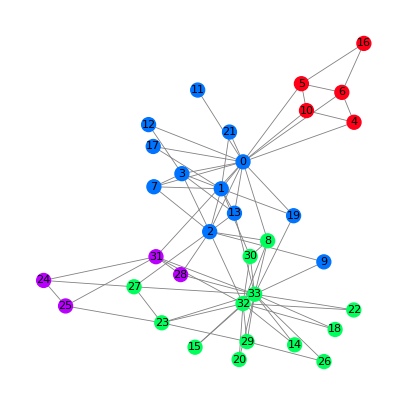

In [23]:
# displaying the network :
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(5,5))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=100,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.6,
                edge_color="grey",
                font_size=8
                )
plt.show()

In [24]:
# Graph Convolutional Network

In [25]:
print(''' 
In traditional neural networks, linear layers apply a linear transformation to the incoming data. 
This transformation converts input features x into hidden vectors h through the use of a weight matrix 𝐖. 

With graph data, an additional layer of complexity is added through the connections between nodes. 
These connections matter because, typically, in networks, it’s assumed that similar nodes are more likely 
to be linked to each other than dissimilar ones, a phenomenon known as NETWORK HOMOPHILY.
''')

 
In traditional neural networks, linear layers apply a linear transformation to the incoming data. 
This transformation converts input features x into hidden vectors h through the use of a weight matrix 𝐖. 

With graph data, an additional layer of complexity is added through the connections between nodes. 
These connections matter because, typically, in networks, it’s assumed that similar nodes are more likely 
to be linked to each other than dissimilar ones, a phenomenon known as NETWORK HOMOPHILY.



In [26]:
print('''
We can enrich our node representation by merging its features with those of its neighbors. 
This operation is called convolution, or neighborhood aggregation. 
Let’s represent the neighborhood of node i including itself as Ñ.

Unlike filters in Convolutional Neural Networks (CNNs), our weight matrix 𝐖 is unique and shared among every node. 
But there is another issue: nodes do not have a fixed number of neighbors like pixels do.
''')


We can enrich our node representation by merging its features with those of its neighbors. 
This operation is called convolution, or neighborhood aggregation. 
Let’s represent the neighborhood of node i including itself as Ñ.

Unlike filters in Convolutional Neural Networks (CNNs), our weight matrix 𝐖 is unique and shared among every node. 
But there is another issue: nodes do not have a fixed number of neighbors like pixels do.



In [27]:
print('''
How do we address cases where one node has only one neighbor, and another has 500? 
If we simply sum the feature vectors, the resulting embedding h would be much larger for the node with 500 neighbors. 
To ensure a similar range of values for all nodes and comparability between them, 
we can normalize the result based on the degree of nodes, where degree refers to the number of connections a node has.
''')


How do we address cases where one node has only one neighbor, and another has 500? 
If we simply sum the feature vectors, the resulting embedding h would be much larger for the node with 500 neighbors. 
To ensure a similar range of values for all nodes and comparability between them, 
we can normalize the result based on the degree of nodes, where degree refers to the number of connections a node has.



In [28]:
print(''' 
Introduced by Kipf et al. (2016), the GRAPH CONVOLUTIONAL LAYER has one final improvement.

The authors observed that features from nodes with numerous neighbors propagate much more easily than 
those from more isolated nodes.
To offset this effect, they suggested assigning bigger weights to features from nodes with fewer neighbors, 
thus balancing the influence across all nodes.

Convolution acts as sliding windows on whole images to learn features from neighboring cells. 
The filter uses weight sharing to learn various facial features in image recognition systems.

Now transfer the same functionality to Graph Convolutional networks where a model learns the features from neighboring nodes. 
''')

 
Introduced by Kipf et al. (2016), the GRAPH CONVOLUTIONAL LAYER has one final improvement.

The authors observed that features from nodes with numerous neighbors propagate much more easily than 
those from more isolated nodes.
To offset this effect, they suggested assigning bigger weights to features from nodes with fewer neighbors, 
thus balancing the influence across all nodes.

Convolution acts as sliding windows on whole images to learn features from neighboring cells. 
The filter uses weight sharing to learn various facial features in image recognition systems.

Now transfer the same functionality to Graph Convolutional networks where a model learns the features from neighboring nodes. 



In [29]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)    
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
        
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [30]:
print('''
We can stack several graph layers to aggregate more and more distant values, but there’s a catch: 
if we add too many layers, the aggregation becomes so intense that all the embeddings end up looking the same. 
This phenomenon is called OVER-SMOOTHING and can be a real problem when you have too many layers.
''')


We can stack several graph layers to aggregate more and more distant values, but there’s a catch: 
if we add too many layers, the aggregation becomes so intense that all the embeddings end up looking the same. 
This phenomenon is called OVER-SMOOTHING and can be a real problem when you have too many layers.



In [31]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

In [32]:
# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()
    
    # Forward pass
    h, z = model(data.x, data.edge_index)
    
    # Calculate loss function
    loss = criterion(z, data.y)
    
    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)
    
    # Compute gradients
    loss.backward()
    
    # Tune parameters
    optimizer.step()
    
    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    
    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.37 | Acc: 38.24%
Epoch  10 | Loss: 1.19 | Acc: 41.18%
Epoch  20 | Loss: 0.95 | Acc: 73.53%
Epoch  30 | Loss: 0.74 | Acc: 73.53%
Epoch  40 | Loss: 0.61 | Acc: 73.53%
Epoch  50 | Loss: 0.52 | Acc: 73.53%
Epoch  60 | Loss: 0.45 | Acc: 85.29%
Epoch  70 | Loss: 0.39 | Acc: 85.29%
Epoch  80 | Loss: 0.33 | Acc: 85.29%
Epoch  90 | Loss: 0.25 | Acc: 88.24%
Epoch 100 | Loss: 0.14 | Acc: 100.00%
Epoch 110 | Loss: 0.06 | Acc: 100.00%
Epoch 120 | Loss: 0.03 | Acc: 100.00%
Epoch 130 | Loss: 0.02 | Acc: 100.00%
Epoch 140 | Loss: 0.01 | Acc: 100.00%
Epoch 150 | Loss: 0.01 | Acc: 100.00%
Epoch 160 | Loss: 0.01 | Acc: 100.00%
Epoch 170 | Loss: 0.01 | Acc: 100.00%
Epoch 180 | Loss: 0.01 | Acc: 100.00%
Epoch 190 | Loss: 0.01 | Acc: 100.00%
Epoch 200 | Loss: 0.01 | Acc: 100.00%


In [33]:
# Visualization :

import matplotlib.pyplot as plt
import matplotlib.animation as animation  # Import the animation module
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import networkx as nx
from torch_geometric.utils import to_networkx  # Assuming PyTorch Geometric

from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

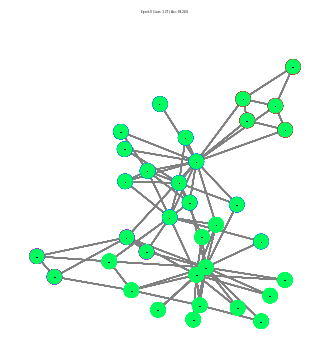

In [34]:
# Define the animate function
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=0),
        with_labels=True,
        node_size=100,
        node_color=outputs[i],
        cmap="hsv",
        vmin=-2,
        vmax=3,
        width=0.8,
        edge_color="grey",
        font_size=1
    )
    plt.title(
        f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
        fontsize=2,
        pad=20
    )

# Create the figure
fig = plt.figure(figsize=(4, 4))
plt.axis('off')

# Create the animation
anim = FuncAnimation(
    fig, animate, frames=np.arange(0, 200, 10), interval=500, repeat=True
)

# Convert to HTML and display
html = HTML(anim.to_html5_video())
display(html)

In [35]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[3.4382e+00, 6.4229e-01, 1.5412e+00],
        [2.9073e+00, 1.5907e+00, 1.0730e-01],
        [2.2599e+00, 1.6673e+00, 6.7400e-01],
        [2.9537e+00, 1.4978e+00, 5.1293e-01],
        [1.9149e+00, 4.1568e-01, 3.2838e+00],
        [2.0466e+00, 5.7248e-02, 3.6502e+00],
        [2.1329e+00, 6.7918e-02, 3.6656e+00],
        [2.3856e+00, 1.5146e+00, 7.0252e-01],
        [7.0727e-01, 2.7717e+00, 0.0000e+00],
        [2.0216e+00, 1.5247e+00, 7.8039e-01],
        [2.0037e+00, 3.9879e-01, 3.3203e+00],
        [2.3410e+00, 1.5074e+00, 6.7088e-01],
        [2.3664e+00, 1.5690e+00, 7.5634e-01],
        [2.1586e+00, 1.7417e+00, 6.3002e-01],
        [5.7826e-01, 2.9066e+00, 9.6817e-02],
        [5.2275e-01, 2.7598e+00, 3.8911e-02],
        [1.9000e+00, 2.7604e-01, 3.4537e+00],
        [2.2454e+00, 1.4617e+00, 8.5232e-01],
        [5.1703e-01, 2.8152e+00, 8.2724e-02],
        [2.0196e+00, 1.5685e+00, 8.0183e-01],
        [5.6122e-01, 2.9107e+00, 6.8789e-

In [36]:
# As you can see, embeddings do not need to have the same dimensions as feature vectors.

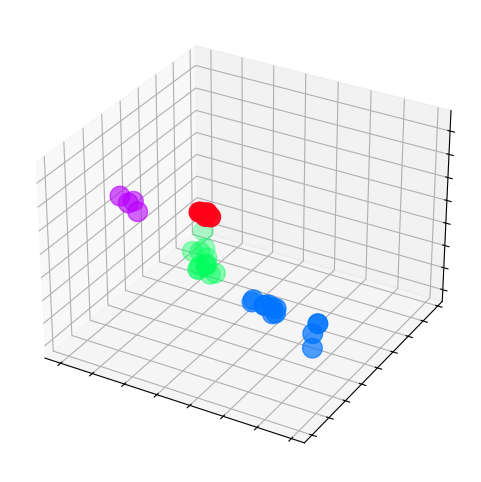

In [37]:
# Get first embedding at epoch = 0
# We see every node from Zachary’s karate club with their true labels (and not the model’s predictions).

embed = h.detach().cpu().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()

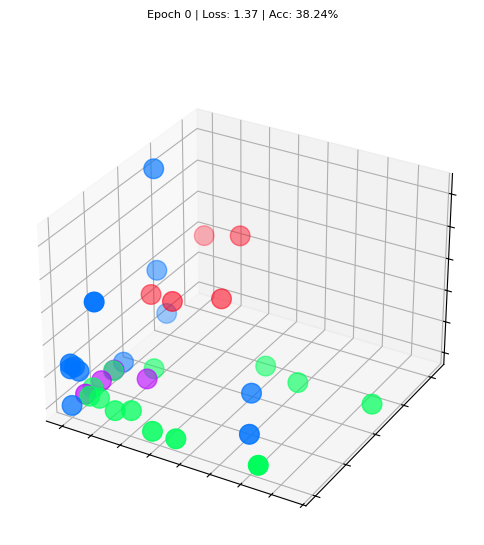

In [38]:
# Let’s see how they evolve over time, as the GCN gets better and better at classifying nodes.

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(
        embed[:, 0], embed[:, 1], embed[:, 2],
        s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3
    )
    plt.title(
        f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
        fontsize=8, pad=40
    )

# Create the figure and set up the 3D plot
fig = plt.figure(figsize=(6, 6))
plt.axis('off')
ax = fig.add_subplot(projection='3d')

plt.tick_params(
    left=False,
    bottom=False,
    labelleft=False,
    labelbottom=False
)

# Create the animation
anim = animation.FuncAnimation(
    fig, animate, frames=np.arange(0, 200, 10), interval=800, repeat=True
)

# Convert to HTML and display
html = HTML(anim.to_html5_video())
display(html)

In [39]:
print(''' 
Although we only talked about node classification in this article, there are other tasks GNNs can accomplish: 
link prediction (e.g., to recommend a friend), 
graph classification (e.g., to label molecules), 
graph generation (e.g., to create new molecules), and so on.
''')

 
Although we only talked about node classification in this article, there are other tasks GNNs can accomplish: 
link prediction (e.g., to recommend a friend), 
graph classification (e.g., to label molecules), 
graph generation (e.g., to create new molecules), and so on.



In [40]:
print('''
Other models :
Graph Autoencoders 
Graph Attention Networks
''')


Other models :
Graph Autoencoders 
Graph Attention Networks

